# Earthquake and Death in China

This script fetches earthquake data from a Wikipedia page to explore patterns and risks associated with earthquakes in China. It is part of a personal research project aimed at understanding earthquake trends and their implications for disaster management.

## Data scrapping and preprocessing

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re

url = 'https://en.wikipedia.org/wiki/List_of_earthquakes_in_China'
response = requests.get(url)

# Validate the response
if response.status_code != 200:
    raise Exception(f"Failed to fetch data from {url}. HTTP Status Code: {response.status_code}")

# Parse the HTML content
soup = BeautifulSoup(response.text, 'html.parser')

# Locate the relevant table
earthquake_table = soup.find('table', class_='wikitable')
if earthquake_table is None:
    raise Exception("Could not find the earthquake data table on the page.")

# Convert the HTML table to a pandas DataFrame
table_html = str(earthquake_table)
df = pd.read_html(table_html)[0]

# Step 5: Data Cleaning
# Replace empty strings with NaN
df.replace(to_replace=r'^\s*$', value=np.nan, regex=True, inplace=True)

# Remove footnotes using regex (e.g., remove patterns like [1], [2])
for column in df.columns:
    df[column] = df[column].apply(lambda x: re.sub(r'\[\d+\]', '', str(x)) if isinstance(x, str) else x)

# Convert numeric columns to proper types (if known)
numeric_columns = ['Magnitude', 'Deaths']  # Adjust based on actual column names
def convert_to_numeric(column):
    return pd.to_numeric(df[column], errors='coerce') if column in df.columns else None

for column in numeric_columns:
    convert_to_numeric(column)

# Preview the cleaned data
print("Preview of the cleaned earthquake data:")
print(df.head())

# Save the cleaned data for further analysis
df.to_csv('earthquake_data_canada.csv', index=False)

print("Data scraping and cleaning completed. The dataset is saved as 'earthquake_data_canada.csv'.")


Preview of the cleaned earthquake data:
         Date                     Article  \
0  c. 1920 BC  Jishi Gorge outburst flood   
1   512-05-21      512 Shaanxi earthquake   
2  1038-01-09   1038 Dingxiang earthquake   
3  1290-09-27       1290 Zhili earthquake   
4  1303-09-25    1303 Hongdong earthquake   

                                   Coord                          Location  \
0              35°N 102°E﻿ / ﻿35°N 102°E                   Qinghai / Gansu   
1    38°54′N 112°48′E﻿ / ﻿38.9°N 112.8°E               Dai County, Shaanxi   
2  38°24′N 112°55′E﻿ / ﻿38.40°N 112.92°E         Dingxiang County, Shaanxi   
3    41°30′N 119°18′E﻿ / ﻿41.5°N 119.3°E  Ningcheng County, Inner Mongolia   
4    36°18′N 111°42′E﻿ / ﻿36.3°N 111.7°E                           Shaanxi   

       Mag            Deaths                         Description Unnamed: 7  \
0      NaN               NaN                                 NaN        NaN   
1   7.5 Ms  5,310 (estimate)                                 N

<ipython-input-2-b574be244c4a>:24: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_html(table_html)[0]


In [3]:
def parse_coords(coord_str):
    """
    Expects a string like:
       '38°24′N 112°55′E﻿ / ﻿38.40°N 112.92°E'
    1) Splits at '/', keeps the decimal chunk (the second part).
    2) Extracts Lat and Lon from something like '38.40°N 112.92°E'.
    3) Returns (lat, lon) as floats, or (None, None) if parsing fails.
    """
    if not isinstance(coord_str, str):
        return (None, None)

    # 1) Split on '/'
    parts = coord_str.split('/')
    if len(parts) < 2:
        return (None, None)

    # The "decimal" part is usually the second chunk (after the slash)
    decimal_part = parts[-1]  # e.g. "﻿38.40°N 112.92°E"

    # Remove hidden characters like the zero-width '﻿' plus any extra whitespace
    decimal_part = decimal_part.replace('﻿', '').strip()
    # Now it should look like "38.40°N 112.92°E"

    # 2) Regex to extract lat and lon
    # Explanation:
    #   (\d+(\.\d+)?) -> captures digits with optional decimal (e.g. 38.40)
    #   °?[NnSs]?     -> might have a ° symbol plus N or S
    #   \s+           -> some whitespace
    #   (\d+(\.\d+)?) -> another digits block for longitude
    #   °?[EeWw]?     -> might have a ° symbol plus E or W
    pattern = r"(\d+(\.\d+)?)°?[NnSs]?\s+(\d+(\.\d+)?)°?[EeWw]?"
    match = re.search(pattern, decimal_part)
    if not match:
        return (None, None)

    lat_str, _, lon_str, _ = match.groups()

    # Convert to floats
    lat = float(lat_str)
    lon = float(lon_str)

    # 3) If the coordinate string includes 'S' or 'W', we flip the sign
    if re.search(r"[Ss]", decimal_part):
        lat = -abs(lat)
    if re.search(r"[Ww]", decimal_part):
        lon = -abs(lon)

    return (lat, lon)
df['Lat'], df['Lon'] = zip(*df['Coord'].apply(parse_coords))


In [4]:
# Drop rows 0 and 1 (the first two), and also the last row
df = df.iloc[2:-1]

In [5]:
# Extract the first 4 consecutive digits
df['Year'] = df['Date'].str.extract(r'(\d{4})')

# Convert to numeric type (in case some rows don't have 4 digits, they'll become NaN)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

In [6]:
# 1. Remove the first two rows and the last row
df = df.iloc[2:-1].reset_index(drop=True)

# 2. Create 'Year' from the first four digits of 'Date'
df['Year'] = df['Date'].str.extract(r'(\d{4})')
df['Year'] = pd.to_numeric(df['Year'], errors='coerce')

# 3. Parse Magnitude
# Corrected regex with only one capturing group
df['MagValue'] = df['Mag'].str.extract(r'(\d+(?:\.\d+)?)')
df['MagValue'] = pd.to_numeric(df['MagValue'], errors='coerce')

# Extract magnitude type (Ms, ML, Mw) and convert to lowercase
df['MagType'] = df['Mag'].str.extract(r'(?i)\b(Ms|ML|Mw)\b')
df['MagType'] = df['MagType'].str.lower()

# 4. Convert 'Deaths' to numeric
df['DeathsNumeric'] = (
    df['Deaths']
    .astype(str)  # Ensure all data is string
    .str.replace(',', '', regex=True)   # Remove commas
    .str.extract(r'(\d+)')               # Extract the first group of digits
    .astype(float)
)

# 5. Define Conversion Factors for Magnitude Types to Mw
# These are approximate and should be refined based on scientific literature
mag_conversion = {
    'ms': lambda x: x - 0.1,   # Example: Ms to Mw
    'ml': lambda x: x + 0.1,   # Example: ML to Mw
    'mw': lambda x: x,         # Mw remains unchanged
}

# 6. Apply Conversion to Create a Unified Magnitude Column (MagMw)
def convert_mag(row):
    mag_type = row['MagType']
    mag_value = row['MagValue']
    if pd.isna(mag_type) or pd.isna(mag_value):
        return np.nan
    conversion_func = mag_conversion.get(mag_type)
    if conversion_func:
        return conversion_func(mag_value)
    else:
        return np.nan  # If MagType is unknown, set as NaN

df['MagMw'] = df.apply(convert_mag, axis=1)

# Optionally fill NaN MagMw with MagValue
df['MagMw'] = df['MagMw'].fillna(df['MagValue'])

# 7. Drop unnecessary columns (Unnamed columns and original Mag)
cols_to_drop = [col for col in df.columns if 'Unnamed:' in col or col == 'Mag']
df.drop(columns=cols_to_drop, inplace=True)

# 8. Validate the Transformations
print("Transformed DataFrame:")
print(df[['Date', 'Year', 'MagValue', 'MagType', 'MagMw', 'Deaths', 'DeathsNumeric']].head(10))


Transformed DataFrame:
         Date  Year  MagValue MagType  MagMw            Deaths  DeathsNumeric
0  1303-09-25  1303       8.0      ml    8.1           270,000       270000.0
1  1337-09-08  1337       6.5      ms    6.4               NaN            NaN
2  1536-03-20  1536       7.5     NaN    7.5         thousands            NaN
3  1556-01-23  1556       8.0      mw    8.0          100,000+       100000.0
4  1604-12-29  1604       8.1      mw    8.1           Unknown            NaN
5  1605-07-13  1605       7.5      ms    7.4  several thousand            NaN
6  1622-10-25  1622       7.2      mw    7.2             12000        12000.0
7  1626-06-28  1626       7.0      ms    6.9            >5,200         5200.0
8  1668-07-25  1668       8.5      mw    8.5             50000        50000.0
9  1679-09-02  1679       8.0      mw    8.0             45500        45500.0


In [7]:
# Remove commas, then extract digits
df['DeathsNumeric'] = (
    df['Deaths']
    .str.replace(',', '', regex=True)   # remove commas
    .str.extract(r'(\d+)')             # extract the first digit group
    .astype(float)
)

print(df[['Deaths', 'DeathsNumeric']].head())


      Deaths  DeathsNumeric
0    270,000       270000.0
1        NaN            NaN
2  thousands            NaN
3   100,000+       100000.0
4    Unknown            NaN


## Data Visualization

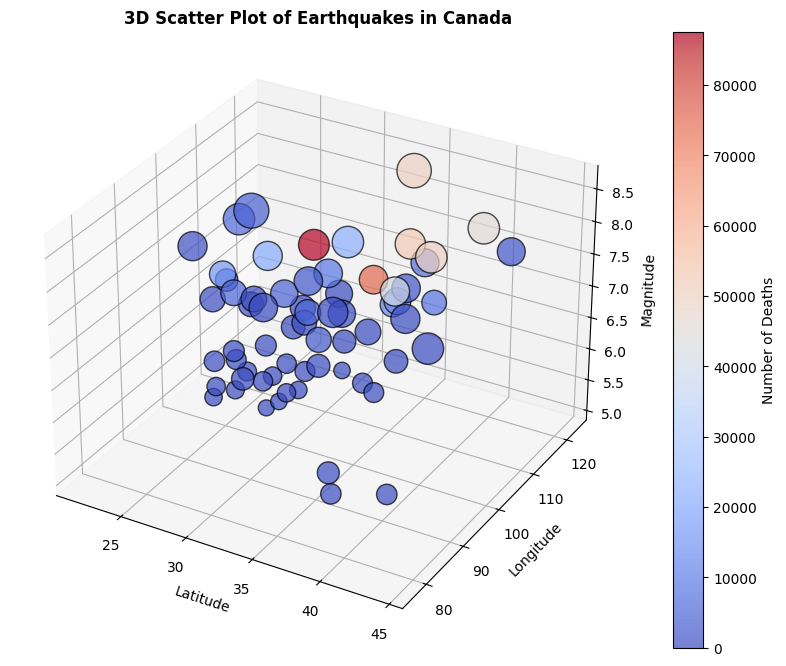

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting

# Ensure the columns are numeric
df['Lat'] = pd.to_numeric(df['Lat'], errors='coerce')
df['Lon'] = pd.to_numeric(df['Lon'], errors='coerce')
df['Mag.'] = pd.to_numeric(df['MagValue'], errors='coerce')
df['Deaths'] = pd.to_numeric(df['Deaths'], errors='coerce')

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Example: color by Deaths, size by Magnitude^3 (just as an example)
p = ax.scatter(
    df['Lat'], df['Lon'], df['Mag.'],
    c=df['Deaths'],      # color
    cmap='coolwarm',
    s=(df['Mag.']**3).fillna(20),  # marker size
    alpha=0.7, edgecolor='k'
)

ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.set_zlabel('Magnitude')
ax.set_title('3D Scatter Plot of Earthquakes in China', weight='bold')
cbar = plt.colorbar(p)
cbar.set_label('Number of Deaths')

plt.show()


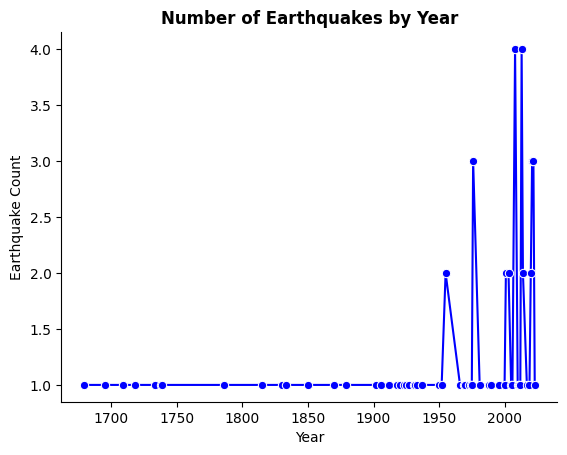

In [11]:
import seaborn as sns

# Convert 'Date' to datetime and extract the year
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df['Year'] = df['Date'].dt.year

# Count how many earthquakes happened each year
yearly_counts = df.groupby('Year').size()

plt.figure()
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker='o', color='blue')
plt.title('Number of Earthquakes by Year', weight='bold')
plt.xlabel('Year')
plt.ylabel('Earthquake Count')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()


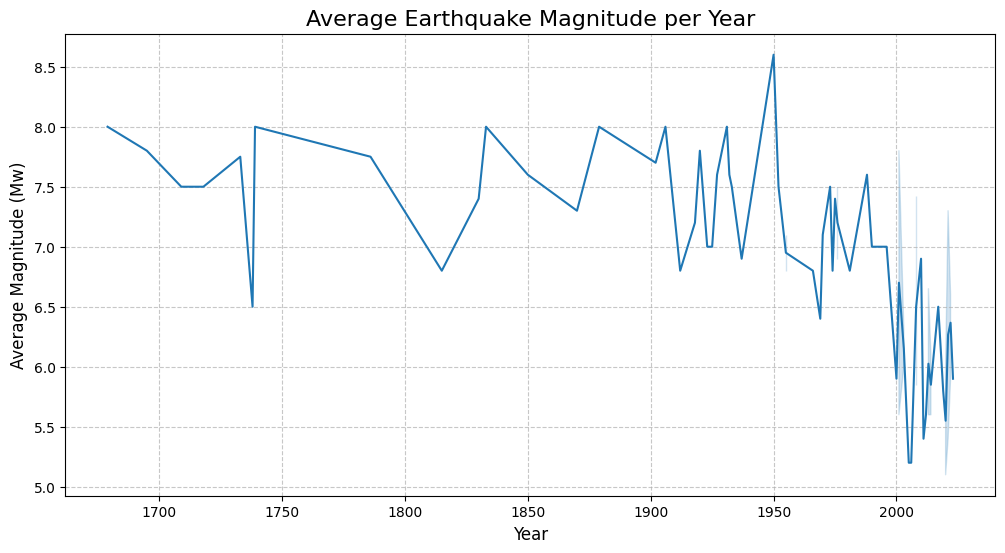

In [24]:


# Average Magnitude per Year
plt.figure(figsize=(12,6))
sns.lineplot(data=df_time, x='Year', y='MagValue', estimator='mean')
plt.title('Average Earthquake Magnitude per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Magnitude (Mw)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


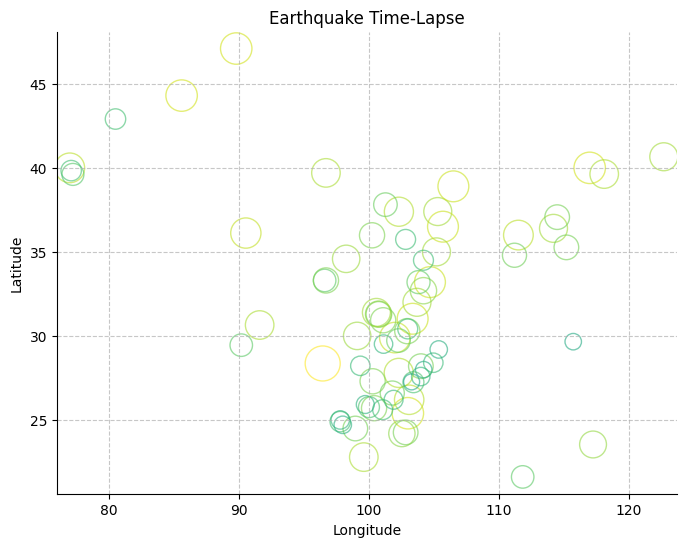

In [12]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# Ensure your DataFrame 'df' has been properly cleaned and includes 'Lat', 'Lon', and 'MagMw'
# If not already done, execute the data cleaning steps provided earlier

# 1. Sort by date and remove any remaining NaN in 'Date'
df_time = df.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

# 2. Verify that 'MagMw' exists
if 'MagMw' not in df_time.columns:
    raise KeyError("The DataFrame does not contain a 'MagMw' column. Please ensure data cleaning steps are correctly applied.")

# 3. Initialize the plot
fig, ax = plt.subplots(figsize=(8,6))
# Initialize with a properly shaped empty array (0 points, 2 coordinates)
scat = ax.scatter([], [], s=50, c='blue', alpha=0.6)

# Set plot limits based on data
lat_min, lat_max = df_time['Lat'].min() - 1, df_time['Lat'].max() + 1
lon_min, lon_max = df_time['Lon'].min() - 1, df_time['Lon'].max() + 1
ax.set_xlim(lon_min, lon_max)  # Typically, Longitude on X-axis
ax.set_ylim(lat_min, lat_max)  # Latitude on Y-axis

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Earthquake Time-Lapse')

# Optional: Improve plot aesthetics
ax.grid(True, linestyle='--', alpha=0.7)
ax.spines[['top', 'right']].set_visible(False)

# 4. Define the initialization function
def init():
    # Set an empty array with shape (0, 2)
    scat.set_offsets(np.empty((0, 2)))
    scat.set_sizes([])  # Optionally clear sizes
    scat.set_array(np.array([]))  # Optionally clear colors if using
    return scat,

# 5. Define the animation function
def animate(i):
    # Slice the DataFrame up to the current frame
    data_slice = df_time.iloc[:i+1]

    # Extract coordinates
    offsets = np.column_stack((data_slice['Lon'], data_slice['Lat']))  # Longitude (X), Latitude (Y)
    scat.set_offsets(offsets)

    # Scale marker sizes based on magnitude (using 'MagMw')
    # To prevent extremely large sizes, you might want to normalize or scale appropriately
    sizes = (data_slice['MagMw'] ** 3).fillna(20)  # Example scaling; adjust as needed
    scat.set_sizes(sizes)

    # Optional: Color by magnitude or any other variable
    scat.set_color(plt.cm.viridis(data_slice['MagMw'] / df_time['MagMw'].max()))

    return scat,

# 6. Create the animation
ani = animation.FuncAnimation(
    fig,
    animate,
    frames=len(df_time),
    init_func=init,
    interval=200,  # Time between frames in milliseconds
    blit=True,     # Use blitting for faster rendering
    repeat=False    # Do not repeat the animation
)

# 7. Display the animation
# If you're using Jupyter Notebook, use the following to embed the animation:
from IPython.display import HTML
HTML(ani.to_jshtml())

# 8. Show the plot (optional if displaying within Jupyter)
plt.show()


In [22]:
import plotly.express as px

# Ensure 'Year' is properly formatted and exists
df_time = df_time.dropna(subset=['Year'])

fig = px.scatter_geo(
    df_time,
    lon='Lon',
    lat='Lat',
    color='MagMw',
    size='MagMw',
    animation_frame='Year',
    projection='natural earth',
    hover_name='Location',
    title='Earthquake Time-Lapse in Canada (Colored by Magnitude Mw)'
)

fig.update_layout(
    geo=dict(showland=True, landcolor="lightgray"),
    legend_title_text='Magnitude (Mw)'
)

fig.show()
